In [15]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import pywt
import h5py
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import numpy as np
import hassCS
import sewar
from scipy.sparse import random as sparse_random

### Getting local filepath and importing the data

In [2]:
import socket
socket.gethostname()

'Paisam'

In [3]:
with open(r'data\data_filepath.txt', 'r') as file:
    pc_name, filepath = file.read().replace('\n', '').split(',')
    
    if socket.gethostname() == pc_name:
        data_filepath = filepath
    else:
        data_filepath = '101024_FluorDot_Center_Above_0p03_0000.h5'

data_filepath

'101024_FluorDot_Center_Above_0p03_0000.h5'

(256, 256, 256)

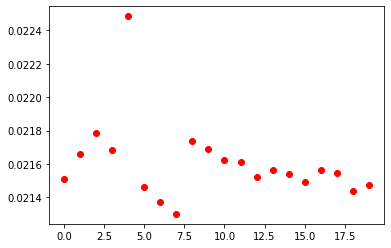

In [4]:
fid = h5py.File('data.h5','r')

arr = np.zeros([256,256,256])
for ix,k in enumerate(fid):
    data = fid[k][()]
    if ix==20:
        break
    arr= data + arr
    # Average signal in each file
    plt.plot(ix,data.mean(),'or')
arr = np.array(arr)
arr.shape

In [5]:
h5file = h5py.File(data_filepath,'r')
key = []
for ix,k in enumerate(h5file):
#         index.append(ix)
    key.append(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


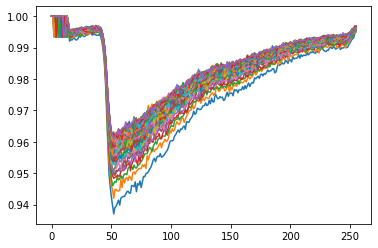

In [6]:
for j in range(45):
    arr1 = np.zeros([256,256,256])
    ordered_sparsity_spectral = []
    images = h5file[key[j]][()]  # Replace 'images' with the actual name of the dataset
    images = np.array(images)
    arr1 += images
    for i in range(256):
        original = arr1[:,:,i]
        gini = hassCS.gini(original)
        ordered_sparsity_spectral.append(gini)
    plt.plot(ordered_sparsity_spectral)
    print(j)


### Here we plot the effects on sparsity when summing over the spectral axis

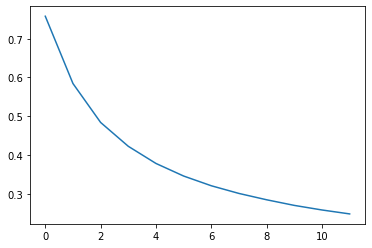

In [7]:
#Sanity check
ordered_sparsity_spectral = []
intensity = []
start_index = 8
for i in range(start_index,20):
    original = arr[:,:,start_index-1:i]
    original = original.sum(2)
    gini = hassCS.gini(original)
#     print(i,original.sum(),gini)
    ordered_sparsity_spectral.append(gini)
    intensity.append(original.sum())
#plt.plot(intensity)
plt.plot(ordered_sparsity_spectral)

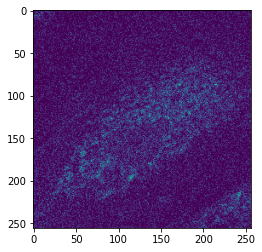

In [8]:
plt.imshow(arr[:,:,48])


# For Compressed Sensing

### Here we run a summation on the spectral axis, increasing the number of frames summed to decrease the levels of sparsity

In [9]:
def spectral_cs(arr, wavelet):
    original = []
    sparsity_spectral = []
    img_corr_spectral = []
    for i in range(50,256):
        original = arr[:,:,i]
#         original = original.sum(2)
        X_reconstructed, Xw = hassCS.single_rec(original,wavelet = wavelet)
        sparsity_spectral.append(hassCS.gini(original))
        img_corr_spectral.append(sewar.scc(original,X_reconstructed))
    return sparsity_spectral, img_corr_spectral

bior_sparse, bior_corr = spectral_cs(arr1,"bior1.3")
# haar_sparse, haar_corr = spectral_cs(arr, "haar")
# rbio_sparse, rbio_corr = spectral_cs(arr, "rbio1.3")

### After running compressed sensing we plot the performance of the algorithm against the decreasing levels of sparsity in the data to find the breaking point

In [10]:
def spectral_plot(sparsity_spectral,img_corr_spectral,wavelet):
    #The lighter the color the larger the slice of spectral used
    cmap = cm.inferno  
    norm = plt.Normalize(0, len(sparsity_spectral))
    fig, axes = plt.subplots()
    colors = cmap(norm(range(len(sparsity_spectral))))
    plt.scatter(sparsity_spectral, img_corr_spectral, c = colors, marker='o', edgecolors='k',s=100, alpha=0.7)

    plt.title(f'Sparsity vs. Image Correlation for Spectral Axis {wavelet}', fontsize=16, fontweight='bold')
    plt.xlabel('Sparsity', fontsize=14)
    plt.ylabel('Image Correlation', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    return plt.plot(sparsity_spectral, img_corr_spectral, color='gray', linewidth=1, alpha=0.7)

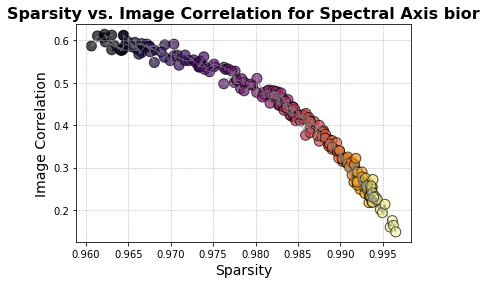

In [11]:
# The color indicates the order of the data (dark->light)
spectral_plot(bior_sparse,bior_corr,"bior")
# spectral_plot(haar_sparse,haar_corr, "haar")
# spectral_plot(rbio_sparse, rbio_corr, "rbio1.4")

### Note: Time axis summation omitted due to no measurable change in sparsity

# For Compression

In [12]:
def wavelet_compr(data,wavelet = "bior1.3",threshold = 20):
    # Applying wavelet transform and storing coefficients
    coeffs = pywt.dwt2(data, wavelet)
    cA, (cH, cV, cD) = coeffs
    
    # Thresholding values to keep only low values
    cA_thresholded = pywt.threshold(cA, threshold, mode='soft')
    cH_thresholded = pywt.threshold(cH, threshold, mode='soft')
    
    #Compress the image
    coeffs_thresholded = (cA_thresholded, (cH_thresholded, cV, cD))
    img_compressed = pywt.idwt2(coeffs_thresholded, 'bior1.3')
    
    return img_compressed

In [16]:
def spectral_c(arr, wavelet):
    original = []
    sparsity_spectral = []
    img_corr_spectral = []
    for i in range(50,256):
        original = arr[:,:,i]
#         original = original.sum(2)
        X_reconstructed = wavelet_compr(original)
        sparsity_spectral.append(hassCS.gini(original))
        img_corr_spectral.append(sewar.scc(original,X_reconstructed))
    return sparsity_spectral, img_corr_spectral

In [17]:
bior_sparse_c, bior_corr_c = spectral_c(arr1,"bior1.3")
# haar_sparse_c, haar_corr_c = spectral_c(arr, "haar")
# rbio_sparse_c, rbio_corr_c = spectral_c(arr, "rbio1.3")

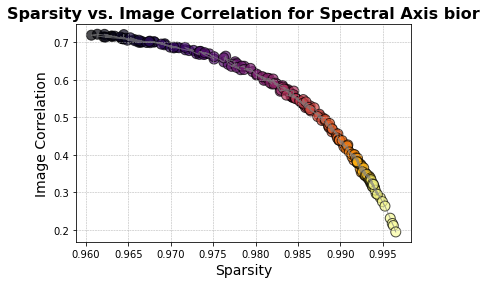

In [18]:
# The color indicates the order of the data (dark->light)
spectral_plot(bior_sparse_c,bior_corr_c,"bior")
# spectral_plot(haar_sparse_c,haar_corr_c, "haar")
# spectral_plot(rbio_sparse_c, rbio_corr_c, "rbio1.4")

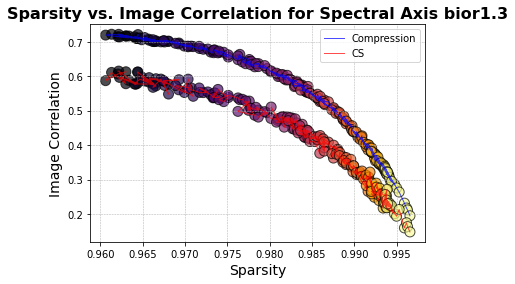

In [19]:
wavelet = "bior1.3"
fig, ax = plt.subplots()

# Create a color map based on the first dataset
cmap = cm.inferno  
norm_c = plt.Normalize(0, len(bior_sparse_c))
colors_c = cmap(norm_c(range(len(bior_sparse_c))))

# Scatter and plot for the first set
plt.scatter(bior_sparse_c, bior_corr_c, c=colors_c, marker='o', edgecolors='k', s=100, alpha=0.7)
ax.plot(bior_sparse_c, bior_corr_c, color='blue', linewidth=1, alpha=0.7, label = 'Compression')

# Create a different color map for the second dataset (or use the same if appropriate)
norm = plt.Normalize(0, len(bior_sparse))
colors = cmap(norm(range(len(bior_sparse))))

# Scatter and plot for the second set
plt.scatter(bior_sparse, bior_corr, c=colors, marker='o', edgecolors='k', s=100, alpha=0.7)
ax.plot(bior_sparse, bior_corr, color='red', linewidth=1, alpha=0.7,label="CS")

# Title and labels
plt.title(f'Sparsity vs. Image Correlation for Spectral Axis {wavelet}', fontsize=16, fontweight='bold')
plt.xlabel('Sparsity', fontsize=14)
plt.ylabel('Image Correlation', fontsize=14)

# Grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

Looks like at around .2 gini level or sparsity level, there is a breaking point in the data

In [24]:

# Generate sparse matrices with varying densities
size = (256, 256)  # Example size
target_sparsity_levels = np.linspace(0, 1, 100)  # Sparsity levels from 0 to 1

data_set = {}
for sparsity in target_sparsity_levels:
    density = 1 - sparsity
    sparse_matrix = sparse_random(size[0], size[1], density=density, format='csr')
    dense_matrix = sparse_matrix.toarray()  # Convert to dense for Gini calculation
    
    gini = hassCS.gini(dense_matrix)
    data_set[sparsity] = dense_matrix
#     print(f"Sparsity Level: {sparsity:.2f}, Gini Coefficient: {gini:.2f}")



array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

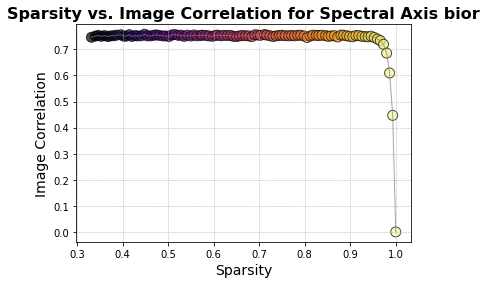

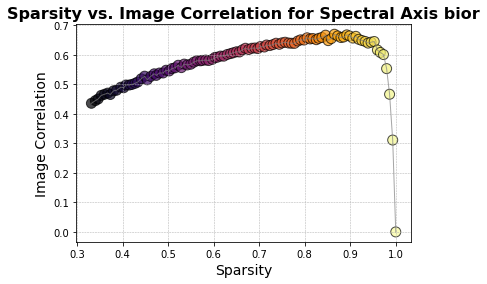

In [26]:
sparsity_spectral = []
img_corr_spectral = []
cs_s = []
cs_corr = []
for target in target_sparsity_levels:
    original = data_set[target]
    X_reconstructed = wavelet_compr(original)
    sparsity_spectral.append(hassCS.gini(original))
    img_corr_spectral.append(sewar.scc(original,X_reconstructed))
    X_reconstructed, Xw = hassCS.single_rec(original,wavelet = wavelet)
    cs_s.append(hassCS.gini(original))
    cs_corr.append(sewar.scc(original,X_reconstructed))
spectral_plot(sparsity_spectral,img_corr_spectral,"bior")
spectral_plot(cs_s,cs_corr,"bior")
